Notebook for Figure 5

In [20]:
%matplotlib inline

import tqdm
import time

import xarray as xr
import numpy as np 

# importing the TDigest package
from crick import TDigest

#Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.patches as patches
import cartopy.crs as ccrs

from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import LogFormatter
from matplotlib.colors import LogNorm

In [22]:
ds = xr.open_dataset("/work/bb1153/b382291/opa_paper_data/pr_aug_2021_ICON_ngc2009_cycle3_r100.nc")
ds

<xarray.Dataset> Size: 771MB
Dimensions:  (time: 1488, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 12kB 2021-08-01 ... 2021-08-31T23:30:00
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    pr       (time, lat, lon) float64 771MB ...

In [23]:
ds.pr

<xarray.DataArray 'pr' (time: 1488, lat: 180, lon: 360)> Size: 771MB
[96422400 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 12kB 2021-08-01 ... 2021-08-31T23:30:00
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Attributes:
    cell_methods:                 t: mean
    long_name:                    precipitation flux
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    units:                        kg m-2 s-1
    regridded:                    1
    history:                      \n2024-03-06 12:28:11 AQUA💧: Regrid from R0...

In [24]:
# extracting data array
pr = ds.pr
#converting the units from precipitation flux in kg m-2 s-1 to mm day-1 (for easier interprobility)
density = 998 # kg/m3 
pr =  (pr / density) * 1000  * 60 * 60 * 24

In [34]:
digest_list = []
time_dim, lat_size, lon_size = np.shape(pr)
grid_size =  lat_size*lon_size
# flatten the lat lon grid
flat_data = np.reshape(pr.values, [len(pr.time), grid_size])

# adding the data for each grid cell to a TDigest object with compression factor of 80
for g in range(grid_size):
    digest = TDigest(compression=80)
    digest.update(flat_data[:,g])
    digest_list.append(digest)

In [51]:
# interested in extreme rainfall so examining the 99th percentile
quantiles = 99

epsilon = 1

total_99per_error = np.zeros([1, grid_size])
total_99_error = np.zeros([1, grid_size])

locations_high = []
locations_toohigh = []

# looping through the flattened grid
for g in tqdm.tqdm(range(grid_size)):

     #extracting the 99th percentile estimate for every grid cell
     quant_res = digest_list[g].quantile(quantiles/100)
     # calculating the numpy estimate of the 99th percentile using the linear interpolation
     np_res = np.percentile(flat_data[:,g], q = quantiles, method = 'linear')
    
     # due to errors extremely close to 0 it is possible for the percentile error to be larger than
     # 100 %. We stabilise the calcluation with the small constant epsilon. See paper for details.
     error = abs(quant_res -  np_res)
     error_per = (abs(quant_res -  np_res) /((np_res) + epsilon)) *100
     
     # if percentage error is still greater than 100, set to 0 for plotting
     if error_per > 100:
          total_99per_error[0, g] = 0
          total_99_error[0, g] = 0
          locations_high.append(flat_data[:,g])
     else:
          total_99per_error[0, g] = error_per
          total_99_error[0, g] = error

print('number of error values set to 0 error is:', len(locations_high))

# reshape array back to lat lon
total_99per_error = np.reshape(total_99per_error, [1, lat_size, lon_size])

  1%|▏         | 877/64800 [00:00<00:07, 8765.85it/s]

100%|██████████| 64800/64800 [00:06<00:00, 9894.41it/s] 

number of error values set to 0 error is: 1


We want to examine a range of different errors from the numpy to TDigest comparision. We start by examining the location with the largest mean rainfall over the month

In [49]:
mean_pr = np.mean(pr, axis = 0)
max_index = np.argmax(mean_pr.values)
max_row, max_col = np.unravel_index(max_index, mean_pr.shape)

Want to examine the locations with the largest error. Here we find the location of the largest percentile error (based on the digests with a compression factor of 80), which corresponds to a location in Brazil

In [106]:
worst_index = np.argmax(total_99per_error)
worst_per_row, worst_per_col = np.unravel_index(worst_index, mean_pr.shape)
total_99per_error[0, worst_per_row, worst_per_col]
print('Worst percentage error:', total_99per_error[0, worst_per_row, worst_per_col], '%')

Worst percentage error: 89.75848528407265 %


In [98]:
total_99_error

array([[0.01364123, 0.00280852, 0.00868983, ..., 0.72841509, 0.76854493,
        0.68928283]])

In [96]:
sorted = np.sort(total_99_error)
sorted[0,-45]
# a, bad_index_flat = np.where(total_99_error == sorted[0,-45])
# worst_row_a, worst_col_a = np.unravel_index(bad_index_flat, mean_pr.shape)
# worst_col_a = worst_col_a[0]
# worst_row_a = worst_row_a[0]

# print(worst_row_a)
# print(worst_col_a)

19.735647105405235

In [104]:
sorted[0][-1]

65.73764656559146

In [89]:
a = np.argmax(total_99_error)
a = 25695
worst_row_a, worst_col_a = np.unravel_index(a, mean_pr.shape)
total_99per_error[0, worst_row_a, worst_col_a]

# worst_row_a = 115
# worst_col_a = 142

print(worst_row_a)
print(worst_col_a)

71
135


Want to examine the locations with the largest error. Here we find the location of the largest percentile error (based on the digests with a compression factor of 80), which corresponds to a location in Brazil

In [50]:
worst_index = np.argmax(total_99per_error)
worst_row, worst_col = np.unravel_index(worst_index, mean_pr.shape)
total_99per_error[0, worst_row, worst_col]

# worst_row = 76 # this for percentage error 
# worst_col = 300

print(worst_row)
print(worst_col)
print('error', total_99per_error[0, worst_row, worst_col])

76
300
error 89.75848528407265


In [90]:

# worst place - BRAZIL
x1 = worst_per_col #95 #2748 # lon = 94.85 (along)
y1 = worst_per_row # 107 #1072 # lat = 17.25 (up)
thailand_tp = pr[:, y1, x1]
thailand_tp

# colombia
#x2 = 347 #1660 # lon = -13.95 (347)
#x2 = 150 # aus bad region 
x2 = max_col
y2 = max_row
colombia_tp = pr[:, y2, x2]
colombia_tp

# pacific ocean
x3 = worst_col_a # = 142 lon #2 # 1820 # lon = 2.05 
y3 = worst_row_a # = 25.5 lat #131 # 1315 # lat = 41.55
spain_tp = pr[:, y3, x3]
spain_tp

# new_york 
x4 = 285 #1050 # lon = -74.95
y4 = 130 # 1307 # lat = 40.75
usa_tp = pr[:, y4, x4]
usa_tp

compression_spacing = 2
max_comp = 140
min_comp = 20
spacing = int((max_comp - min_comp)/compression_spacing)+1
compressions = np.linspace(min_comp, max_comp, spacing)
num_compressions = len(compressions)

digest_list_t = []
digest_list_c = []
digest_list_s = []
digest_list_u = []

for i in range(num_compressions): 
    digest_list_t.append(TDigest(compression = compressions[i]))
    digest_list_c.append(TDigest(compression = compressions[i]))
    digest_list_s.append(TDigest(compression = compressions[i]))
    digest_list_u.append(TDigest(compression = compressions[i]))

    #for j in range(len(thailand_tp)):
    #digest_list[i].update(full_data[j])
    digest_list_t[i].update(thailand_tp)
    digest_list_c[i].update(colombia_tp)
    digest_list_s[i].update(spain_tp)
    digest_list_u[i].update(usa_tp)

In [91]:
# plotting compression vs error 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

digests_99p_t = np.zeros(num_compressions)
digests_99p_c = np.zeros(num_compressions)
digests_99p_s = np.zeros(num_compressions)
digests_99p_u = np.zeros(num_compressions)

centriod_num_t = np.zeros(num_compressions)
centriod_num_c = np.zeros(num_compressions)
centriod_num_s = np.zeros(num_compressions)
centriod_num_u = np.zeros(num_compressions)

quantiles = 99
for i in range(num_compressions):
    digests_99p_t[i] = digest_list_t[i].quantile(quantiles/100)
    digests_99p_c[i] = digest_list_c[i].quantile(quantiles/100)
    digests_99p_s[i] = digest_list_s[i].quantile(quantiles/100)
    digests_99p_u[i] = digest_list_u[i].quantile(quantiles/100)

    centriod_num_t[i] = np.size(digest_list_t[i].centroids())
    centriod_num_c[i] = np.size(digest_list_c[i].centroids())
    centriod_num_s[i] = np.size(digest_list_s[i].centroids())
    centriod_num_u[i] = np.size(digest_list_u[i].centroids())

errors = np.zeros([4, num_compressions])
errors_p = np.zeros([4, num_compressions])
errors_p_log = np.zeros([4, num_compressions])
errors_bars = np.zeros([8, num_compressions])
errors_bars_p = np.zeros([8, num_compressions])
errors_bars_p_log = np.zeros([8, num_compressions])
error_other = np.zeros([8, 4, num_compressions])
percen_np = np.zeros([8])

for h in range(4):
    if h == 0:
        full_data = thailand_tp
        digests_99p = digests_99p_t
    elif h == 1:
        full_data = colombia_tp
        digests_99p = digests_99p_c
    elif h == 2:
        full_data = spain_tp
        digests_99p = digests_99p_s
    else:  
        full_data = usa_tp
        digests_99p = digests_99p_u

    percen_np[7] = np.percentile(full_data, q = quantiles, method = 'linear')
    percen_np[0] = np.percentile(full_data, q = quantiles, method = 'inverted_cdf')
    percen_np[1] = np.percentile(full_data, q = quantiles, method = 'averaged_inverted_cdf')
    percen_np[2] = np.percentile(full_data, q = quantiles, method = 'closest_observation')
    percen_np[3] = np.percentile(full_data, q = quantiles, method = 'interpolated_inverted_cdf')
    percen_np[4] = np.percentile(full_data, q = quantiles, method = 'hazen')
    percen_np[5] = np.percentile(full_data, q = quantiles, method = 'weibull')
    percen_np[6] = np.percentile(full_data, q = quantiles, method = 'normal_unbiased')

    errors[h, :] = (digests_99p - percen_np[7])
    errors_p[h,:] = errors[h, :]/(percen_np[7] + epsilon) * 100

    errors_p_log[h,:] = np.log10(abs(errors[h, :])/(percen_np[7] + epsilon) * 100) 

    for kl in range(len(digests_99p)): # looping through compressions 
        errors_bars[2*h+1, kl] = ((np.max(digests_99p[kl] - percen_np))  - (errors[h,kl])) # upper 
        
        errors_bars[2*h, kl] = (errors[h,kl] - np.min(digests_99p[kl] - percen_np)) # lower 
        
        errors_bars_p[(2*h)+1, kl] = ((np.max((digests_99p[kl] - percen_np)/(percen_np + epsilon)))  
                                      - errors[h,kl]/(percen_np[7]+ epsilon)) * 100 # upper 
        
        errors_bars_p[2*h, kl] = (errors[h,kl]/(percen_np[7] + epsilon) 
                                  - np.min((digests_99p[kl] - percen_np)/(percen_np+epsilon))) * 100 # lower 

        # errors_bars_p_log[(2*h)+1, kl] = abs(np.log10(((np.max((digests_99p[kl] - percen_np)/(percen_np + epsilon)))  
        #                               - errors[h,kl]/(percen_np[7]+ epsilon)) * 100)) # upper 
        
        # errors_bars_p_log[2*h, kl] = (np.log10(np.min((digests_99p[kl] - percen_np)/(percen_np+epsilon))
        #                               * 100)) # lower 

        error_other[:, h, kl] = (digests_99p[kl] - percen_np)/percen_np * 100 

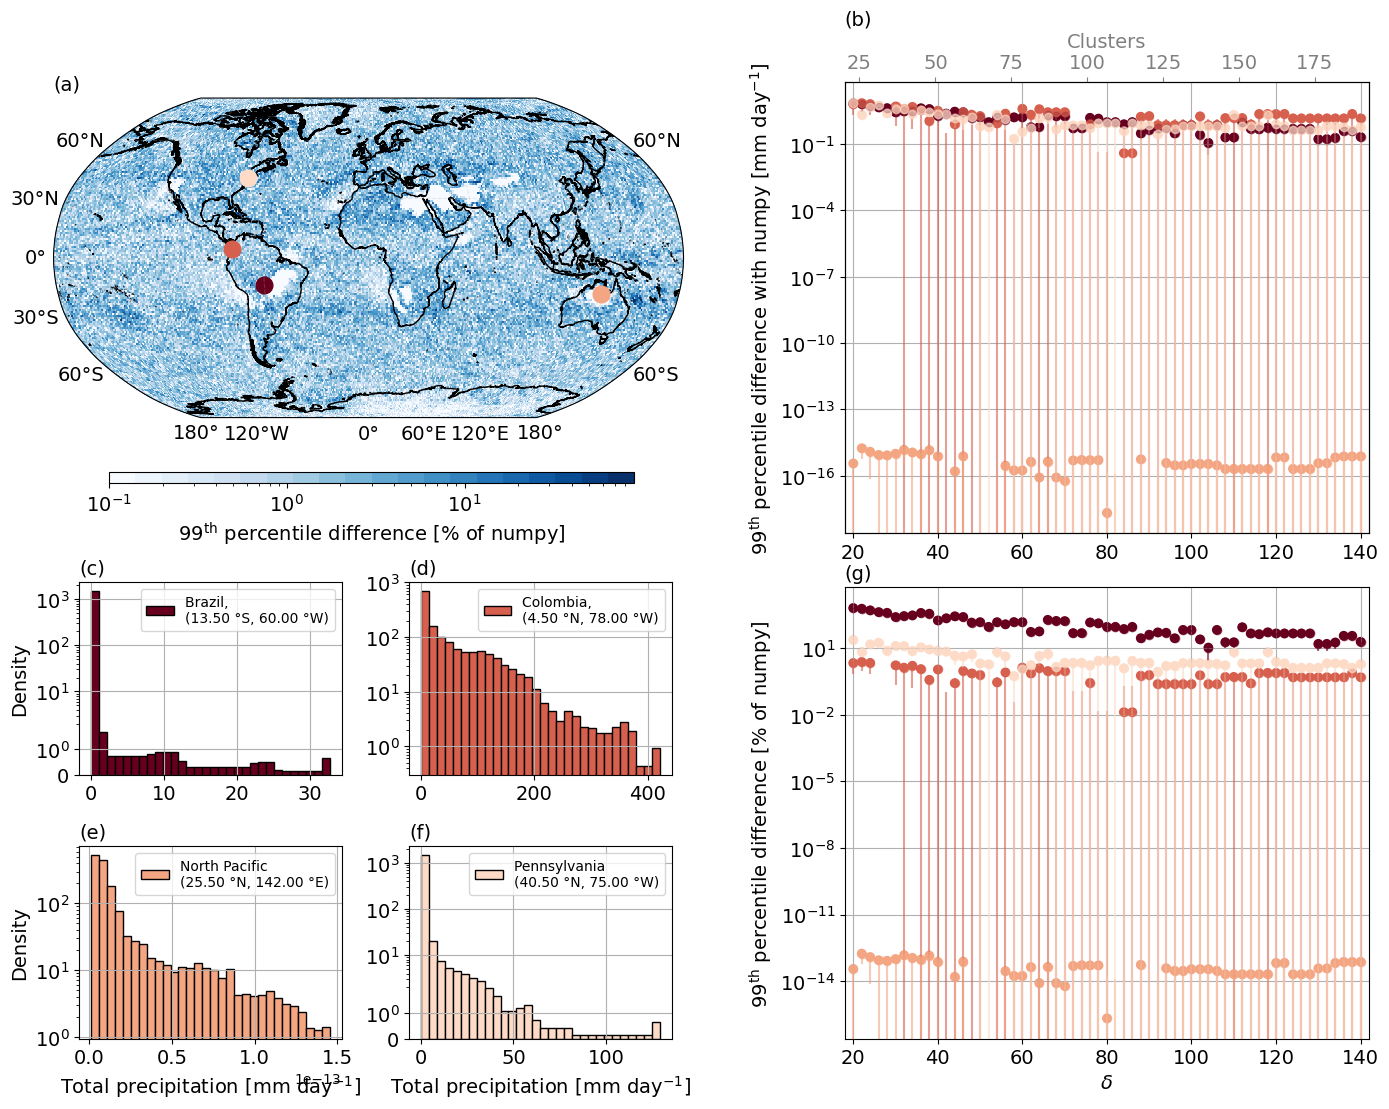

In [92]:
robinson = ccrs.Robinson()
geodetic = ccrs.Geodetic()
fig = plt.figure(constrained_layout=False, figsize=(15,11)) # 14 was 9 
fig.subplots_adjust(bottom=0.1, top=0.97, left=0.01, right=0.9, wspace = 0.2, hspace = 0.25)
nrow = 2
ncol = 2
outer = gs.GridSpec(nrow,ncol,wspace=0.3,hspace=0.12, width_ratios=[0.85, 0.7])
square_size = 20  # Size of the square (you can adjust this as needed)
fsize = 14

# thailand 
# lon = 94.85 
# lat = 17.25
c1 = '#67001f' #ca0020' #'#a6cee3'

# colombia
# lon = 282 (-78)
# lat = 4.5
c2 = '#d6604d' #'#1f78b4'

# spain
# lon = 346.2 (13.8)
# lat = 9.95
c3 = '#f4a582'# blue '#92c5de' #'#b2df8a'

# america 
c4 = '#fddbc7' # blue '#0571b0' #'#33a02c'

for i in range(nrow*ncol):
    
    if i == 0:
        
        #ax = plt.subplot(outer[i],projection = robinson)
        ax = fig.add_axes([0.023, 0.60, 0.42, 0.42], projection = robinson)  # [left, bottom, width, height]

        fig.subplots_adjust(bottom=0.05, top=0.99, left=0.01, right=0.9, wspace = 0.2, hspace = 0.4)
        ax.coastlines(resolution = '10m') #Draws the coastline.
        #ax.add_feature(cfeature.LAKES, edgecolor = 'black') #Adds lakes.
        #ax.add_feature(cfeature.RIVERS) #Adds rivers.
        gl = ax.gridlines(draw_labels = True,linestyle='dashed',alpha=0.25) #Draws meridians and parallels.
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': fsize}
        gl.ylabel_style = {'size': fsize}

        cmap = plt.get_cmap('Blues', 20)
        lon2d,lat2d = np.meshgrid(pr.lon, pr.lat)

        cs = ax.pcolormesh(lon2d, lat2d, total_99per_error[0,:,:], transform=ccrs.PlateCarree(),
                           cmap=cmap, norm = LogNorm(vmin = 0.1))
        
        lon1 = pr.lon[x1].values
        lat1 = pr.lat[y1].values

        lon2 = pr.lon[x2].values
        lat2 = pr.lat[y2].values

        lon3 = pr.lon[x3].values
        lat3 = pr.lat[y3].values
        
        lon4 = pr.lon[x4].values
        lat4 = pr.lat[y4].values
        
        #Transform the coordinates of the rectangles to the projection coordinates
        rect1 = robinson.transform_point(lon1, lat1, geodetic)
        rect2 = robinson.transform_point(lon2, lat2, geodetic)
        rect3 = robinson.transform_point(lon3, lat3, geodetic)
        rect4 = robinson.transform_point(lon4, lat4, geodetic)

        ax.plot(rect1[0], rect1[1], color=c1, marker='o', markersize=12,
                transform=robinson)
        ax.plot(rect2[0], rect2[1], color=c2, marker='o', markersize=12,
            transform=robinson)
        ax.plot(rect3[0], rect3[1], color=c3, marker='o', markersize=12,
            transform=robinson)
        ax.plot(rect4[0], rect4[1], color=c4, marker='o', markersize=12,
            transform=robinson)
        ax.set_title('(a)', fontsize = fsize, loc = 'left')
        # Add color bar for each subplot
        cbar_ax = fig.add_axes([0.06, 0.605, 0.35, 0.01])  # Adjust the positions for colorbars
        cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')  

        #cbar.set_ticks(cbar.get_ticks()[::-1])        
        cbar.set_label(r"99$^{\text{th}}$ percentile difference [$\%$ of numpy]", rotation=0, fontsize = fsize)
        cbar.ax.tick_params(labelsize=fsize)
        cbar.update_ticks()

    elif i == 2:

        ss = 0.175
        # top left
        # Create inset axes for the histogram
        ax_hist = fig.add_axes([0.04, 0.34, ss, ss])  # [left, bottom, width, height]

        bins_space = 30
        hist_data = digest_list_t[30].histogram(bins_space)
        bins =  hist_data[1]
        weights = hist_data[0]
        ax_hist.hist(bins[:-1], bins = bins, weights = weights, color = c1, edgecolor='black',
                    alpha = 1, label = '''Brazil, \n(13.50 °S, 60.00 °W)''')
        ax_hist.set_ylabel('Density', fontsize=fsize)
        ax_hist.tick_params('y', colors='black', labelsize=fsize)
        ax_hist.tick_params('x', colors='black', labelsize=fsize)
        ax_hist.grid(True)
        ax_hist.set_title('(c)', fontsize = fsize, loc = 'left')
        ax_hist.set_yscale('symlog',base = 10, subs = [2, 3, 4, 5, 6, 7, 8, 9])
        ax_hist.legend(ncol=2)
        # top right 
        bins_space = 30
        hist_data = digest_list_c[30].histogram(bins_space)
        bins =  hist_data[1]
        weights = hist_data[0]
        ax_hist = fig.add_axes([0.26, 0.34, ss, ss])  # [left, bottom, width, height]
        ax_hist.hist(bins[:-1], bins = bins, weights = weights, color = c2, edgecolor='black', 
                     alpha = 1, log = True, label = '''Colombia, \n(4.50 °N, 78.00 °W)''')
        ax_hist.tick_params('y', colors='black', labelsize=fsize)
        ax_hist.tick_params('x', colors='black', labelsize=fsize)
        ax_hist.grid(True)
        ax_hist.legend()
        ax_hist.set_title('(d)', fontsize = fsize, loc = 'left')
        #ax_hist.set_yscale('log',base = 10, subs = [2, 3, 4, 5, 6, 7, 8, 9])

        # bottom left
        #Create inset axes for the histogram
        ax_hist = fig.add_axes([0.04, 0.10, ss, ss])  # [left, bottom, width, height]
            
        bins_space = 30
        hist_data = digest_list_s[30].histogram(bins_space)
        bins =  hist_data[1]
        weights = hist_data[0]
        ax_hist.hist(bins[:-1], bins = bins, weights = weights, color = c3, edgecolor='black', 
                     alpha = 1, log = True, label = '''North Pacific \n(25.50 °N, 142.00 °E)''')
        ax_hist.set_xlabel(r'Total precipitation [mm day$^{-1}$]', fontsize=fsize)
        ax_hist.set_ylabel('Density', fontsize=fsize)
        ax_hist.tick_params('y', colors='black', labelsize=fsize)
        ax_hist.tick_params('x', colors='black', labelsize=fsize)
        ax_hist.grid(True)
        ax_hist.legend()
        ax_hist.set_title('(e)', fontsize = fsize, loc = 'left')
        #ax_hist.set_yscale('log',base = 10, subs = [2, 3, 4, 5, 6, 7, 8, 9])

        # bottom right
        bins_space = 30
        hist_data = digest_list_u[30].histogram(bins_space)
        bins =  hist_data[1]
        weights = hist_data[0]
        #Create inset axes for the histogram
        ax_hist = fig.add_axes([0.26, 0.10, ss, ss])  # [left, bottom, width, height]
        ax_hist.hist(bins[:-1], bins = bins, weights = weights, color = c4, edgecolor='black', 
                     alpha = 1, label = '''Pennsylvania \n(40.50 °N, 75.00 °W)''')
        ax_hist.set_xlabel(r'Total precipitation [mm day$^{-1}$]', fontsize=fsize)
        ax_hist.set_yscale('log', subs = [2, 3, 4, 5, 6, 7, 8, 9])
        ax_hist.tick_params('y', colors='black', labelsize=fsize)
        ax_hist.tick_params('x', colors='black', labelsize=fsize)
        ax_hist.grid(True)
        ax_hist.legend()
        ax_hist.set_title('(f)', fontsize = fsize, loc = 'left')
        ax_hist.set_yscale('symlog', subs = [ 2, 3, 4, 5, 6, 7, 8, 9])
    
    elif i == 1:
        alpha = 0.6
        fig.subplots_adjust(bottom=0.1, top=0.97, left=0.01, right=0.9, wspace = 0.2, hspace = 0.2)
        
        ax = plt.subplot(outer[i])
        ax.errorbar(compressions, errors[0, :], yerr = errors_bars[0:2, :], marker = 'o', color=c1,
                    alpha = 0.6, linestyle='')
        ax.errorbar(compressions, errors[1, :], yerr = errors_bars[2:4, :], marker = 'o', color=c2,
                    alpha = 0.6, linestyle='')
        ax.errorbar(compressions, errors[2, :], yerr = errors_bars[4:6, :], marker = 'o', color=c3,
                    alpha = 0.6, linestyle='')
        ax.errorbar(compressions, errors[3, :], yerr = errors_bars[6:8, :], marker = 'o', color=c4,
                    alpha = 0.6, linestyle='')
        ax.set_ylabel(r'99$^{\text{th}}$ percentile difference with numpy [mm day$^{-1}$]', fontsize=fsize)
        ax.set_xlim([np.min(compressions)-2, np.max(compressions)+2])
        ax.tick_params('y', colors='black', labelsize=fsize)
        ax.tick_params('x', colors='black', labelsize=fsize)
        ax.grid(True)
        ax.set_yscale('log')
        ax.set_title('(b)', fontsize = fsize, loc = 'left')
        
        ax.scatter(compressions, errors[0, :], marker = 'o', color=c1, linestyle='') #,
        ax.scatter(compressions, errors[1, :], marker = 'o', color=c2, linestyle='')
        ax.scatter(compressions, errors[2, :], marker = 'o', color=c3, linestyle='')
        ax.scatter(compressions, errors[3, :], marker = 'o', color=c4, linestyle='')
        #ax.legend(loc='upper right', fontsize=fsize)

        #Create a second x-axis sharing the same x-axis
        ax2 = ax.twiny()
        ax2.scatter(centriod_num_u, errors[0, :], color='gray', marker = '')
        ax2.set_xlabel('Clusters', color='gray', fontsize = fsize)
        ax2.tick_params('x', colors='gray', labelsize = fsize)

    elif i == 3:
        ax = plt.subplot(outer[i])
                
        ax.errorbar(compressions, errors_p[0, :], yerr = errors_bars_p[0:2, :], 
                    marker = 'o', color=c1,linestyle='', alpha=alpha)
        ax.errorbar(compressions, errors_p[1, :], yerr = errors_bars_p[2:4, :], 
                    marker = 'o', color=c2,linestyle='', alpha=alpha)
        ax.errorbar(compressions, errors_p[2, :], yerr = errors_bars_p[4:6, :], 
                    marker = 'o', color=c3,linestyle='', alpha=alpha)
        ax.errorbar(compressions, errors_p[3, :], yerr = errors_bars_p[6:8, :], 
                    marker = 'o', color=c4,linestyle='', alpha=alpha)

#label = 'lat: 9.95 N, lon: 13.95 W (Guinea)'
        ax.scatter(compressions, errors_p[0, :], marker = 'o', color=c1,linestyle='',
                   label = 'Thailand') #'lat: 17.5 N, lon: 95.0  E (
        ax.scatter(compressions, errors_p[1, :], marker = 'o', color=c2,linestyle='',
                   label =  'Colombia') #'lat: 4.5 N, lon: 78.0 W
        ax.scatter(compressions, errors_p[2, :], marker = 'o', color=c3,linestyle='',
                   label = 'Spain') # lat: 41.5 N, lon: 2.0 E 
        ax.scatter(compressions, errors_p[3, :], marker = 'o', color=c4,linestyle='',
                   label = 'Pennsylvania') # lat: 40.5 N, lon: 75.0 W 
        ax.set_yscale('log')
        ax.set_xlim([np.min(compressions)-2, np.max(compressions)+2])
        ax.set_xlabel(r'$\delta$', fontsize=fsize)
        ax.set_ylabel(r'99$^{\text{th}}$ percentile difference [% of numpy]', fontsize=fsize)
        #ax.legend(loc='upper right', fontsize=fsize)
        ax.tick_params('y', colors='black', labelsize=fsize)
        ax.tick_params('x', colors='black', labelsize=fsize)
        ax.grid(True)
        ax.set_title('(g)', fontsize = fsize, loc = 'left')

plt.show()